## Forecasting Continuous Variable Using Linear Regression With Stochastic Gradient Descent ##


### Import Dependencies ###

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### Load Data ###

In [2]:
df = pd.read_csv(r"C:\Users\User\Python Projects\ML Projects\Linear Regression With SGD\nba_games_data.csv")
df.head()

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,...,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
0,1,194611010TRH,NBA,0,1947,11/1/1946,1,0,TRH,Huskies,...,40.294830,NYK,Knicks,68,1300.0000,1306.7233,H,L,0.640065,NaN
1,1,194611010TRH,NBA,1,1947,11/1/1946,1,0,NYK,Knicks,...,41.705170,TRH,Huskies,66,1300.0000,1293.2767,A,W,0.359935,NaN
2,2,194611020CHS,NBA,0,1947,11/2/1946,1,0,CHS,Stags,...,42.012257,NYK,Knicks,47,1306.7233,1297.0712,H,W,0.631101,NaN
3,2,194611020CHS,NBA,1,1947,11/2/1946,2,0,NYK,Knicks,...,40.692783,CHS,Stags,63,1300.0000,1309.6521,A,L,0.368899,NaN
4,3,194611020DTF,NBA,0,1947,11/2/1946,1,0,DTF,Falcons,...,38.864048,WSC,Capitols,50,1300.0000,1320.3811,H,L,0.640065,NaN


In [3]:
#df.info()

### Data Cleaning ###

In [4]:
# Removing the 'notes' column as only 5424 of the records have information
df = df.drop(columns = 'notes', axis = 1)

#Converting date_game from object (str) to date datatype
df['date_game'] = pd.to_datetime(df['date_game'])

# The given data has dates upto 2015. Any date with year in the future, such as 2046 is actually 1946
#Hence we offset the dates which are in the future by 100
df.loc[df['date_game'].dt.year >= 2016, 'date_game'] -= pd.DateOffset(years=100)

#Extracting 'month' and 'year' from the 'date_game' into new columns
df['game_year'] = pd.DatetimeIndex(df['date_game']).year
df['game_month'] = pd.DatetimeIndex(df['date_game']).month

#Dropping game_id, and 'lg_id' as they are nominal
df = df.drop(columns = ['game_id', 'lg_id'], axis = 1)

#Dropping _iscopy as it is only used as a marker for records
df = df.drop(columns = ['_iscopy'], axis = 1)

### Data Preparation ###

In [5]:
#Identifying categorical variables for encoding
categorical_variables = df.select_dtypes(include = "object").columns
print (categorical_variables)

Index(['team_id', 'fran_id', 'opp_id', 'opp_fran', 'game_location',
       'game_result'],
      dtype='object')


In [6]:
#Encoding all categorical variables, apart from game_result
df['team_id'] = df['team_id'].astype('category')
df['team_id'] = df['team_id'].cat.codes

df['fran_id'] = df['fran_id'].astype('category')
df['fran_id'] = df['fran_id'].cat.codes

df['opp_id'] = df['opp_id'].astype('category')
df['opp_id'] = df['opp_id'].cat.codes

df['opp_fran'] = df['opp_fran'].astype('category')
df['opp_fran'] = df['opp_fran'].cat.codes

df['game_location'] = df['game_location'].astype('category')
df['game_location'] = df['game_location'].cat.codes

#Encoding game_result using mapping
df['game_result'] = df['game_result'].map({'W': 1, 'L': 0})

**Identifying relevant independent variables using correlation**

In [7]:
# Correlation to 'forecast' variable
forecast_corr = df.corr(numeric_only = True)
forecast_corr['forecast'].sort_values(ascending = False)

forecast         1.000000e+00
win_equiv        5.679823e-01
game_location    5.618459e-01
elo_i            5.460675e-01
elo_n            5.432202e-01
game_result      4.299058e-01
pts              2.178615e-01
opp_id           5.627642e-03
opp_fran         2.282525e-03
is_playoffs      1.412979e-11
game_year       -2.329306e-11
year_id         -2.615831e-11
gameorder       -3.396295e-11
game_month      -8.427734e-11
seasongame      -1.167542e-03
fran_id         -2.282525e-03
team_id         -5.627642e-03
opp_pts         -2.178615e-01
opp_elo_n       -5.432202e-01
opp_elo_i       -5.460675e-01
Name: forecast, dtype: float64

In [8]:
# Correlation to 'game_result' variable
result_corr = df.corr(numeric_only = True)
result_corr['game_result'].sort_values(ascending = False)

game_result      1.000000e+00
forecast         4.299058e-01
pts              3.632029e-01
win_equiv        3.194290e-01
elo_n            3.055263e-01
game_location    2.446826e-01
elo_i            2.335478e-01
opp_id           4.423151e-03
opp_fran         2.534106e-03
year_id          2.844381e-15
game_year        2.837677e-15
gameorder        2.643207e-15
is_playoffs      2.663445e-17
game_month      -1.242027e-16
seasongame      -7.244415e-04
fran_id         -2.534106e-03
team_id         -4.423151e-03
opp_elo_i       -2.335478e-01
opp_elo_n       -3.055263e-01
opp_pts         -3.632029e-01
Name: game_result, dtype: float64

From the correlation matrices for 'forecast' and 'game_result' it is observed that the independent variables with significant correlation to 'forecast' and 'game_result' are,
1. pts
2. win_equiv
3. elo_n
4. game_location
5. elo_i
6. opp_elo_i
7. opp_elo_n
8. opp_pts
<br>
Creating a feature matrix (X) with the eight relevant independent variables. Creating y_1 and y_2 as label matrices for 'forecast' and 'game_result' variables

In [9]:
y_1 = df['forecast'] # label vector for 'forecast' variable
y_2 = df['game_result'] # label vector for 'game_result' variable
X = df[['pts', 'win_equiv', 'elo_n', 'game_location', 'elo_i', 'opp_elo_i', 'opp_elo_n',\
       'opp_pts']] # Feature matrix

### Linear Regression with Stochastic Gradient Descent - Target Variable 'forecast' ###

In [10]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y_1, test_size = .2, random_state = 42)

In [11]:
# Configuring SGD Regressor
SGD = SGDRegressor(penalty="l2")

parameters = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'loss': ['squared_loss', 'huber'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}
reg = GridSearchCV(estimator = SGD, param_grid = parameters, cv = 2, verbose = 3)

reg.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END alpha=0.1, learning_rate=constant, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=0.1, learning_rate=constant, loss=squared_loss;, score=nan total time=   0.0s
[CV 1/2] END alpha=0.1, learning_rate=constant, loss=huber;, score=-1171221336.346 total time=   0.0s
[CV 2/2] END alpha=0.1, learning_rate=constant, loss=huber;, score=-808690939.348 total time=   0.0s
[CV 1/2] END alpha=0.1, learning_rate=optimal, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=0.1, learning_rate=optimal, loss=squared_loss;, score=nan total time=   0.0s
[CV 1/2] END alpha=0.1, learning_rate=optimal, loss=huber;, score=-40.694 total time=   0.2s
[CV 2/2] END alpha=0.1, learning_rate=optimal, loss=huber;, score=-9.745 total time=   0.2s
[CV 1/2] END alpha=0.1, learning_rate=invscaling, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=0.1, learning_rate=invscaling, loss=squared_los

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/2] END alpha=0.1, learning_rate=invscaling, loss=huber;, score=-29578.154 total time=   3.7s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/2] END alpha=0.1, learning_rate=invscaling, loss=huber;, score=-124797.234 total time=   3.7s
[CV 1/2] END alpha=0.01, learning_rate=constant, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=0.01, learning_rate=constant, loss=squared_loss;, score=nan total time=   0.0s
[CV 1/2] END alpha=0.01, learning_rate=constant, loss=huber;, score=-182507375.124 total time=   0.0s
[CV 2/2] END alpha=0.01, learning_rate=constant, loss=huber;, score=-424493400.681 total time=   0.0s
[CV 1/2] END alpha=0.01, learning_rate=optimal, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=0.01, learning_rate=optimal, loss=squared_loss;, score=nan total time=   0.0s
[CV 1/2] END alpha=0.01, learning_rate=optimal, loss=huber;, score=-157.962 total time=   0.8s
[CV 2/2] END alpha=0.01, learning_rate=optimal, loss=huber;, score=-13.911 total time=   0.8s
[CV 1/2] END alpha=0.01, learning_rate=invscaling, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alph

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/2] END alpha=0.01, learning_rate=invscaling, loss=huber;, score=-48364.777 total time=   3.4s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/2] END alpha=0.01, learning_rate=invscaling, loss=huber;, score=-62171.800 total time=   3.3s
[CV 1/2] END alpha=0.001, learning_rate=constant, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=0.001, learning_rate=constant, loss=squared_loss;, score=nan total time=   0.0s
[CV 1/2] END alpha=0.001, learning_rate=constant, loss=huber;, score=-1203610454.850 total time=   0.0s
[CV 2/2] END alpha=0.001, learning_rate=constant, loss=huber;, score=-181840805.602 total time=   0.0s
[CV 1/2] END alpha=0.001, learning_rate=optimal, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=0.001, learning_rate=optimal, loss=squared_loss;, score=nan total time=   0.0s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/2] END alpha=0.001, learning_rate=optimal, loss=huber;, score=-27.756 total time=   2.6s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/2] END alpha=0.001, learning_rate=optimal, loss=huber;, score=-556.730 total time=   2.5s
[CV 1/2] END alpha=0.001, learning_rate=invscaling, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=0.001, learning_rate=invscaling, loss=squared_loss;, score=nan total time=   0.0s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/2] END alpha=0.001, learning_rate=invscaling, loss=huber;, score=-5641.497 total time=   3.3s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/2] END alpha=0.001, learning_rate=invscaling, loss=huber;, score=-204553.259 total time=   3.3s
[CV 1/2] END alpha=0.0001, learning_rate=constant, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=0.0001, learning_rate=constant, loss=squared_loss;, score=nan total time=   0.0s
[CV 1/2] END alpha=0.0001, learning_rate=constant, loss=huber;, score=-93226945.063 total time=   0.0s
[CV 2/2] END alpha=0.0001, learning_rate=constant, loss=huber;, score=-1549301477.380 total time=   0.0s
[CV 1/2] END alpha=0.0001, learning_rate=optimal, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=0.0001, learning_rate=optimal, loss=squared_loss;, score=nan total time=   0.0s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/2] END alpha=0.0001, learning_rate=optimal, loss=huber;, score=-290535.061 total time=   2.4s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/2] END alpha=0.0001, learning_rate=optimal, loss=huber;, score=-4630.225 total time=   2.5s
[CV 1/2] END alpha=0.0001, learning_rate=invscaling, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=0.0001, learning_rate=invscaling, loss=squared_loss;, score=nan total time=   0.0s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/2] END alpha=0.0001, learning_rate=invscaling, loss=huber;, score=-260875.387 total time=   3.4s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/2] END alpha=0.0001, learning_rate=invscaling, loss=huber;, score=-1187.011 total time=   3.9s
[CV 1/2] END alpha=1e-05, learning_rate=constant, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=1e-05, learning_rate=constant, loss=squared_loss;, score=nan total time=   0.0s
[CV 1/2] END alpha=1e-05, learning_rate=constant, loss=huber;, score=-1287802955.849 total time=   0.0s
[CV 2/2] END alpha=1e-05, learning_rate=constant, loss=huber;, score=-20639482.644 total time=   0.0s
[CV 1/2] END alpha=1e-05, learning_rate=optimal, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=1e-05, learning_rate=optimal, loss=squared_loss;, score=nan total time=   0.0s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/2] END alpha=1e-05, learning_rate=optimal, loss=huber;, score=-3117956.807 total time=   2.6s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/2] END alpha=1e-05, learning_rate=optimal, loss=huber;, score=-3246569.802 total time=   2.8s
[CV 1/2] END alpha=1e-05, learning_rate=invscaling, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=1e-05, learning_rate=invscaling, loss=squared_loss;, score=nan total time=   0.0s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/2] END alpha=1e-05, learning_rate=invscaling, loss=huber;, score=-13576.866 total time=   3.6s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/2] END alpha=1e-05, learning_rate=invscaling, loss=huber;, score=-174627.796 total time=   3.5s
[CV 1/2] END alpha=1e-06, learning_rate=constant, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=1e-06, learning_rate=constant, loss=squared_loss;, score=nan total time=   0.0s
[CV 1/2] END alpha=1e-06, learning_rate=constant, loss=huber;, score=-881583444.073 total time=   0.0s
[CV 2/2] END alpha=1e-06, learning_rate=constant, loss=huber;, score=-1579145318.888 total time=   0.0s
[CV 1/2] END alpha=1e-06, learning_rate=optimal, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=1e-06, learning_rate=optimal, loss=squared_loss;, score=nan total time=   0.0s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/2] END alpha=1e-06, learning_rate=optimal, loss=huber;, score=-1752347856.475 total time=   2.5s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/2] END alpha=1e-06, learning_rate=optimal, loss=huber;, score=-2449478746.694 total time=   2.5s
[CV 1/2] END alpha=1e-06, learning_rate=invscaling, loss=squared_loss;, score=nan total time=   0.0s
[CV 2/2] END alpha=1e-06, learning_rate=invscaling, loss=squared_loss;, score=nan total time=   0.0s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/2] END alpha=1e-06, learning_rate=invscaling, loss=huber;, score=-58132.713 total time=   3.8s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
36 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, *

[CV 2/2] END alpha=1e-06, learning_rate=invscaling, loss=huber;, score=-146784.967 total time=   3.7s


GridSearchCV(cv=2, estimator=SGDRegressor(),
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
                         'learning_rate': ['constant', 'optimal', 'invscaling'],
                         'loss': ['squared_loss', 'huber']},
             verbose=3)

In [12]:
# The best hyperparameters are
reg.best_params_

{'alpha': np.float64(0.1), 'learning_rate': 'optimal', 'loss': 'huber'}

In [13]:
# Plugging in the best hyperparameters along with feature scaling
sgd_reg = make_pipeline(StandardScaler(), SGDRegressor(alpha=0.1, eta0=0.001, fit_intercept=True,
       learning_rate='optimal', loss='huber',
       penalty='l2', power_t=0.25, shuffle=False,
       verbose=0))
sgd_reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.1, eta0=0.001, learning_rate='optimal',
                              loss='huber', shuffle=False))])

In [14]:
sgd_pred_train = sgd_reg.predict(X_train)
sgd_pred_test = sgd_reg.predict(X_test)

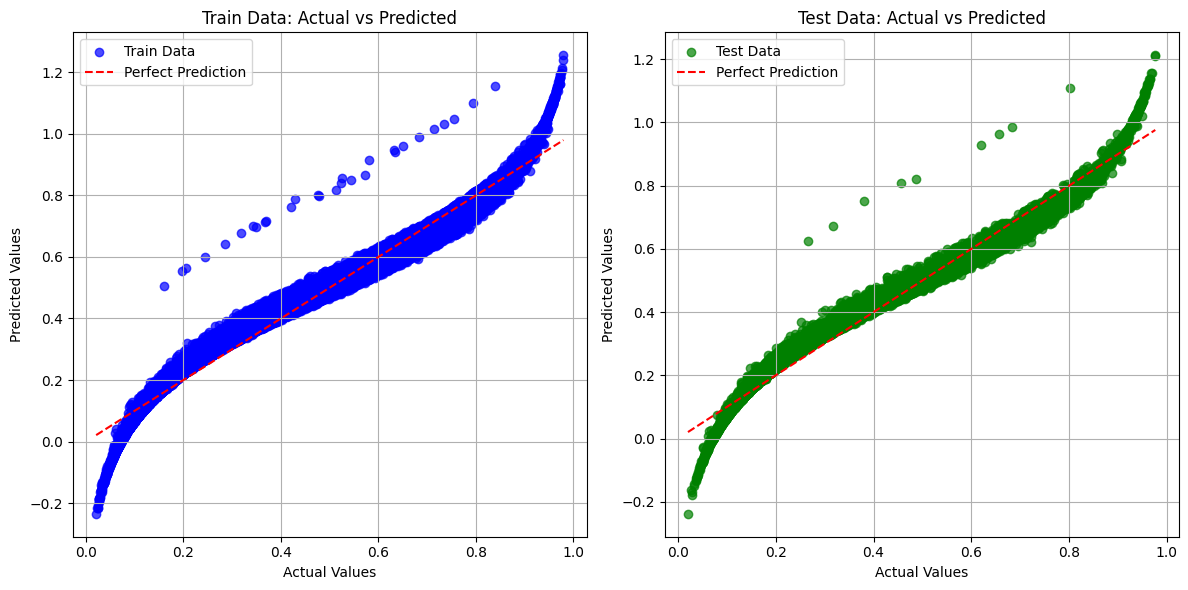

In [15]:
# Scatter plot for training data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, sgd_pred_train, alpha=0.7, color='blue', label='Train Data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect Prediction')
plt.title("Train Data: Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid()

# Scatter plot for testing data
plt.subplot(1, 2, 2)
plt.scatter(y_test, sgd_pred_test, alpha=0.7, color='green', label='Test Data')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.title("Test Data: Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()


### Result ###

In [16]:
test_error_sgd = mean_squared_error(y_test, sgd_pred_test)
train_error_sgd = mean_squared_error(y_train, sgd_pred_train)

print("Train MSE: ", train_error_sgd)
print("Test MSE: ", test_error_sgd)

score_sgd = sgd_reg.score(X_train, y_train)
print("R-squared (SGD):", score_sgd)

Train MSE:  0.0010562719757176956
Test MSE:  0.0010824301895807744
R-squared (SGD): 0.9771702105779482


**With an R-squared value of 0.97, Mean Squared Error on train set of 0.001 and Mean Squared Error on test set of 0.001, the model performs well in predicting the win-loss forecast of a game**